# Convert2Images and Train
- Image Conversion taken from `https://github.com/thongonary/LCDJets/blob/master/Transform.py` - __tested!__
- For each row, produce an image from a matrix of features 
- Train... __testing...__

- To launch, see the env setup in preprocessing_... and then:
```
pyspark --master yarn --packages org.diana-hep:root4j:0.1.6 --jars /afs/cern.ch/work/v/vkhriste/public/spark-root_2.11-0.1.16.jar --executor-memory 4G  --executor-cores 4 --num-executors 25 --files $KRB5CCNAME#krbcache --conf spark.executorEnv.KRB5CCNAME='FILE:$PWD/krbcache' --conf spark.driver.extraClassPath="/usr/lib/hadoop/EOSfs.jar"
```

## Read in the Preprocessed Data
- QCD samples
- TTBar samples
- W+Jets samples

In [1]:
qcd_features = sqlContext.read.format("parquet").load("hdfs:/cms/bigdatasci/vkhriste/data/qcd_preprocessing/test_1530_12122017")
ttbar_features = sqlContext.read.format("parquet").load("hdfs:/cms/bigdatasci/vkhriste/data/ttbar_preprocessing/test_2200_11122017")
wjets_features = sqlContext.read.format("parquet").load("hdfs:/cms/bigdatasci/vkhriste/data/wjets_preprocessing/test_1030_12122017")

In [2]:
qcd_features.show()

+--------------------+--------------------+
|           hfeatures|           lfeatures|
+--------------------+--------------------+
|[100.228340148925...|[WrappedArray(99....|
|[42.2832412719726...|[WrappedArray(34....|
|[0.0, 12.81347084...|[WrappedArray(204...|
|[0.0, 65.22929382...|[WrappedArray(179...|
|[0.0, 16.83046531...|[WrappedArray(203...|
|[0.0, 4.743223190...|[WrappedArray(50....|
|[50.4907798767089...|[WrappedArray(51....|
|[0.0, 53.21599578...|[WrappedArray(61....|
|[0.0, 2.571652889...|[WrappedArray(46....|
|[41.7809562683105...|[WrappedArray(29....|
|[58.6198959350585...|[WrappedArray(40....|
|[0.0, 32.54497146...|[WrappedArray(28....|
|[53.9156837463378...|[WrappedArray(668...|
|[84.5948333740234...|[WrappedArray(127...|
|[0.0, 25.22752761...|[WrappedArray(70....|
|[96.4648742675781...|[WrappedArray(70....|
|[0.0, 18.52447128...|[WrappedArray(360...|
|[0.0, 9.786623001...|[WrappedArray(119...|
|[184.848709106445...|[WrappedArray(64....|
|[0.0, 59.09547805...|[WrappedAr

In [3]:
ttbar_features.show()

+--------------------+--------------------+
|           hfeatures|           lfeatures|
+--------------------+--------------------+
|[962.852188110351...|[WrappedArray(249...|
|[352.717723846435...|[WrappedArray(167...|
|[242.214546203613...|[WrappedArray(67....|
|[100.947238922119...|[WrappedArray(28....|
|[59.9977836608886...|[WrappedArray(64....|
|[493.494388580322...|[WrappedArray(52....|
|[267.234786987304...|[WrappedArray(241...|
|[206.327716827392...|[WrappedArray(63....|
|[383.656970977783...|[WrappedArray(135...|
|[173.195686340332...|[WrappedArray(76....|
|[69.5480575561523...|[WrappedArray(40....|
|[181.502624511718...|[WrappedArray(46....|
|[333.205291748046...|[WrappedArray(97....|
|[73.81298828125, ...|[WrappedArray(481...|
|[109.182903289794...|[WrappedArray(75....|
|[239.590858459472...|[WrappedArray(106...|
|[645.563568115234...|[WrappedArray(575...|
|[125.917373657226...|[WrappedArray(95....|
|[440.674312591552...|[WrappedArray(28....|
|[514.676177978515...|[WrappedAr

In [4]:
wjets_features.show()

+--------------------+--------------------+
|           hfeatures|           lfeatures|
+--------------------+--------------------+
|[0.0, 52.68512344...|[WrappedArray(185...|
|[0.0, 48.29389953...|[WrappedArray(349...|
|[0.0, 34.79087448...|[WrappedArray(220...|
|[0.0, 21.25173377...|[WrappedArray(285...|
|[0.0, 57.50206756...|[WrappedArray(148...|
|[46.7039146423339...|[WrappedArray(160...|
|[0.0, 15.00487327...|[WrappedArray(45....|
|[0.0, 79.79054260...|[WrappedArray(104...|
|[0.0, 41.56198120...|[WrappedArray(248...|
|[85.4285049438476...|[WrappedArray(199...|
|[0.0, 34.41744995...|[WrappedArray(47....|
|[0.0, 45.74290084...|[WrappedArray(43....|
|[0.0, 16.20509147...|[WrappedArray(35....|
|[0.0, 29.39954376...|[WrappedArray(44....|
|[0.0, 62.23700714...|[WrappedArray(174...|
|[0.0, 37.56029129...|[WrappedArray(27....|
|[0.0, 20.01223564...|[WrappedArray(37....|
|[0.0, 15.26028919...|[WrappedArray(37....|
|[0.0, 41.44536590...|[WrappedArray(59....|
|[0.0, 29.08719253...|[WrappedAr

## Step1 Build up the functionality
- various imports
- conversion function
- __Note:__ adding local site-package only needed for a driver!
- __Note:__ `reload(six)` is used because somehow default location of six is chosen (most likely during the import sys, six is loaded as well...) -> since it has been loaded, updating the `sys.path` will not influence that... __Have to reload the module__

In [5]:
import sys
sys.path.insert(0, "/afs/cern.ch/user/v/vkhriste/.local/lib/python2.7/site-packages")
import six
print six.__version__
reload(six)
print six.__version__

1.9.0
1.11.0


In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time, os
from pyspark.sql import Row
import math
from scipy import misc
import random
from skimage import draw

matplotlib.__version__

'2.1.1'

In [7]:
sys.path

['/afs/cern.ch/user/v/vkhriste/.local/lib/python2.7/site-packages',
 u'/tmp/spark-6b358f86-c686-4b55-9947-c6b1ffb76b9a/userFiles-0e2cb921-45c6-46e8-824b-2e5fdac2f1ee/jakarta-regexp_jakarta-regexp-1.4.jar',
 u'/tmp/spark-6b358f86-c686-4b55-9947-c6b1ffb76b9a/userFiles-0e2cb921-45c6-46e8-824b-2e5fdac2f1ee/org.tukaani_xz-1.2.jar',
 u'/tmp/spark-6b358f86-c686-4b55-9947-c6b1ffb76b9a/userFiles-0e2cb921-45c6-46e8-824b-2e5fdac2f1ee/org.apache.bcel_bcel-5.2.jar',
 u'/tmp/spark-6b358f86-c686-4b55-9947-c6b1ffb76b9a/userFiles-0e2cb921-45c6-46e8-824b-2e5fdac2f1ee/org.diana-hep_root4j-0.1.6.jar',
 u'/tmp/spark-6b358f86-c686-4b55-9947-c6b1ffb76b9a/userFiles-0e2cb921-45c6-46e8-824b-2e5fdac2f1ee',
 '',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/prettytable-0.7.2-py2.7.egg',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/distribute-0.6.49-py2.7.egg',
 '/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python

In [8]:
#from skimage import draw 

In [9]:
from pyspark.sql import Row

In [10]:
feature_variables = ['Energy', 'Px', 'Py', 'Pz', 'Pt', 'Eta', 'Phi', 
                    'vtxX', 'vtxY', 'vtxZ','ChPFIso', 'GammaPFIso', 'NeuPFIso',
                    'isChHad', 'isNeuHad', 'isGamma', 'isEle',  'isMu', 
                        #'Charge'
           ]


# In[259]:

colors = {'isMu' : 'green',
        'isEle': 'green',
         'isGamma':'blue',
         'isChHad' : 'red',
         'isNeuHad': 'yellow'}

shapes = {'isMu' : 5,
          'isEle': 5,
          'isGamma':3,
          'isChHad' : 4,
          'isNeuHad': 0}

c_colors = [colors[k] for k in feature_variables[13:]]+['black']
cc_colors = [np.asarray(matplotlib.colors.to_rgb(k)) for k in c_colors]
cc_shapes = [shapes[k] for k in feature_variables[13:]]+[0]

print c_colors
print cc_colors
print cc_shapes

['red', 'yellow', 'blue', 'green', 'green', 'black']
[array([ 1.,  0.,  0.]), array([ 1.,  1.,  0.]), array([ 0.,  0.,  1.]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.        ,  0.50196078,  0.        ]), array([ 0.,  0.,  0.])]
[4, 0, 3, 5, 5, 0]


In [11]:
def showImage(image):
    fig = plt.figure(frameon=False)
    plt.imshow(image.swapaxes(0,1))
    plt.axis('off')
    plt.savefig('fig.png', dpi=100, bbox_inches='tight', pad_inches=0)
    plt.show()

def create3D(data):
    import sys
    sys.path.insert(0, "/afs/cern.ch/user/v/vkhriste/.local/lib/python2.7/site-packages")
    max_eta = 5
    max_phi = np.pi
    res= 100
    neta = int(max_eta*res)
    nphi = int(max_phi*res)
    eeta = 2.*max_eta / float(neta)
    ephi = 2.*max_phi / float(nphi)
    def ieta( eta ): return (eta+max_eta) / eeta
    def iphi(phi) : return (phi+max_phi) / ephi
    blend = 0.3
    image = np.ones((neta,nphi,3), dtype = np.float32)
    
    for ip in range(data.shape[0]):
        p_data = data[ip,:]
        eta = p_data[0]
        phi = p_data[1]
        if eta==0 and phi==0: 
            #print ip
            continue
        #pT = p_data[2]
        #lpT = min(max(np.log(pT)/5.,0.001), 10)*res/2.
        lpT = p_data[2]
        ptype = int(p_data[3])
        c = cc_colors[ ptype ]
        s = cc_shapes[ ptype ]
        R = lpT * res/1.5
        iee = ieta(eta)
        ip0 = iphi(phi)
        ip1 = iphi(phi+2*np.pi)
        ip2 = iphi(phi-2*np.pi)
        
        if s==0:
            xi0,yi0 = draw.circle(  iee, ip0,radius=R, shape=image.shape[:2])
            xi1,yi1 = draw.circle( iee, ip1, radius=R, shape=image.shape[:2])
            xi2,yi2 = draw.circle( iee, ip2, radius=R, shape=image.shape[:2]) 
            #if ptype == 5:
            #    print "MET",eta,phi
        else:
            nv = s
            vx = [iee + R*np.cos(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy = [ip0 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy1 = [ip1 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            vy2 = [ip2 + R*np.sin(ang) for ang in np.arange(0,2*np.pi, 2*np.pi/nv)]
            xi0,yi0 = draw.polygon( vx, vy , shape=image.shape[:2])
            xi1,yi1 = draw.polygon( vx, vy1 , shape=image.shape[:2])
            xi2,yi2 = draw.polygon( vx, vy2 , shape=image.shape[:2])
            
        xi = np.concatenate((xi0,xi1,xi2))
        yi = np.concatenate((yi0,yi1,yi2))
        image[xi,yi,:] = (image[xi,yi,:] *(1-blend)) + (c*blend)
    return image


def convert2image(row):
    """Assume that a row contains a non-empty 2D matrix of features"""
    lmat = np.asarray(row.lfeatures, dtype=np.float64)
    hmat = np.asarray(row.hfeatures, dtype=np.float64)
    
    # low level features
    l_reduced = np.asarray(np.zeros((lmat.shape[0], 4)))
    l_reduced[:, 0] = lmat[:, 5]
    l_reduced[:, 1] = lmat[:, 6]
    l_reduced[:, 2] = np.minimum(np.log(np.maximum(lmat[:, 4], 1.001))/5., 10)
    l_reduced[:, 3] = np.argmax(lmat[:, 13:], axis=-1)
    
    # high level features
    h_reduced = np.zeros( (1, 4))
    h_reduced[0,2] = np.minimum(np.maximum(np.log(hmat[1])/5.,0.001), 10) # MET
    h_reduced[0,1] = hmat[2] # MET-phi
    h_reduced[0,3] = int(5) ## met type
    
    # concatenate the high and low level features
    reduced = np.concatenate((l_reduced, h_reduced), axis=0)
    
    # geneate the image (as a 3D matrix)
    img = create3D(reduced)
    
    return Row(image=img.tolist())

## RUN the pipeline: Get the images from preprocessed features
- qcd 
- ttbar
- wjets

In [12]:
before = time.time()
qcd_images = qcd_features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 24 seconds


In [13]:
before = time.time()
ttbar_images = ttbar_features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 4 seconds


In [14]:
before = time.time()
wjets_images = wjets_features\
    .rdd\
    .map(convert2image)\
    .toDF()
after = time.time()
print("Total Processing Time: %d seconds" % int(after - before))

Total Processing Time: 2 seconds


## Validate the schema for the produced images

In [15]:
qcd_images.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [16]:
ttbar_images.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



In [17]:
wjets_images.printSchema()

root
 |-- image: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: double (containsNull = true)



## Validate the generated images
- qcd
- ttbar
- wjets

In [18]:
qcd_test_images = qcd_images.take(10)
ttbar_test_images = ttbar_images.take(10)
wjets_test_images = wjets_images.take(10)

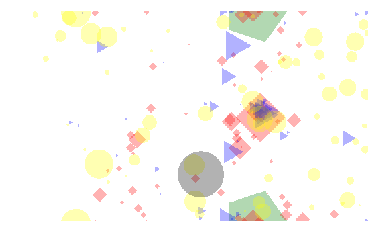

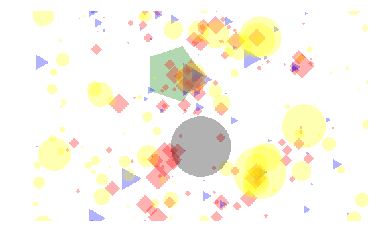

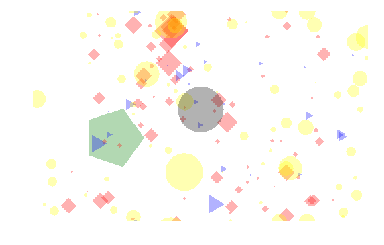

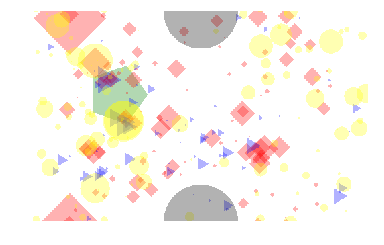

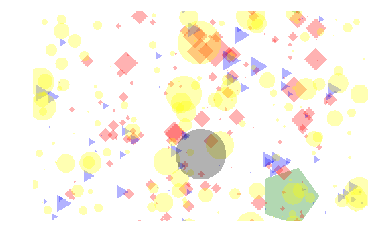

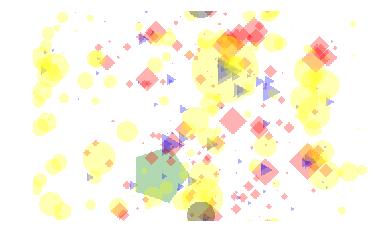

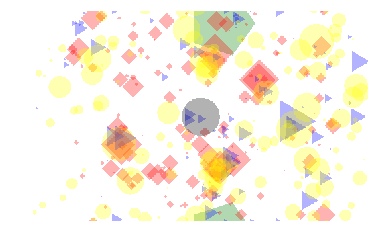

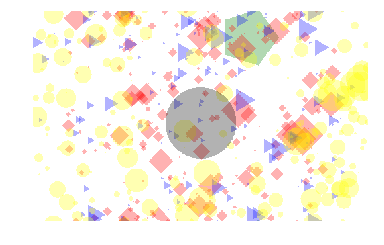

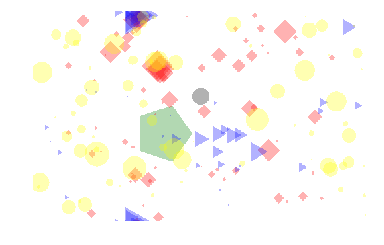

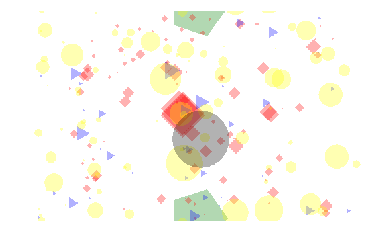

In [19]:
for x in qcd_test_images:
    data = np.asarray(x.image)
    img = create3D(data)
    showImage(img)

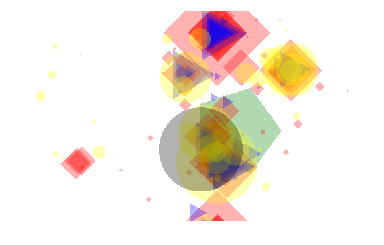

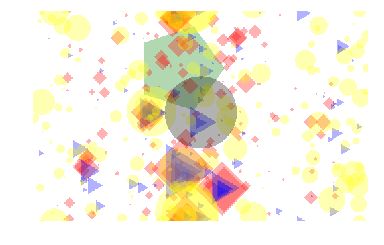

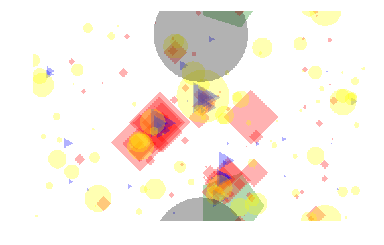

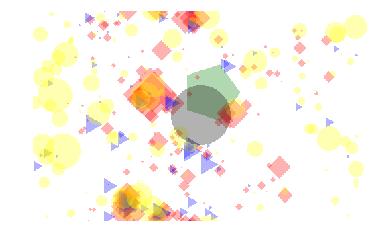

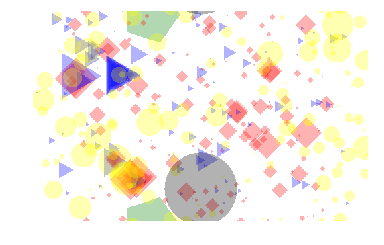

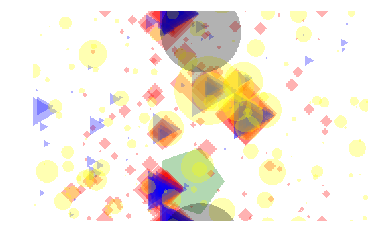

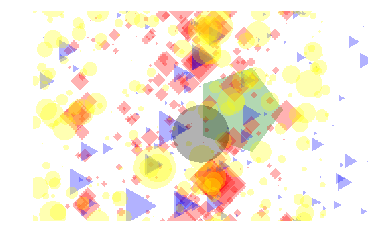

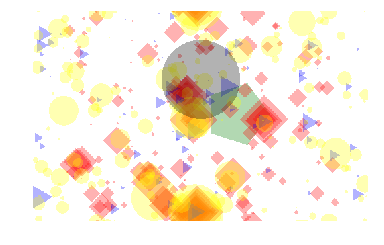

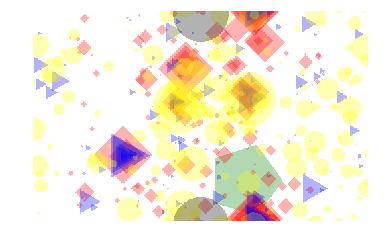

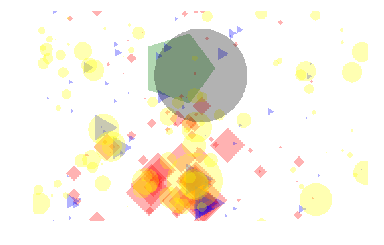

In [20]:
for x in ttbar_test_images:
    data = np.asarray(x.image)
    img = create3D(data)
    showImage(img)

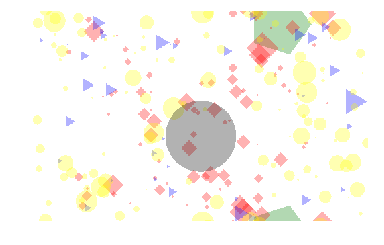

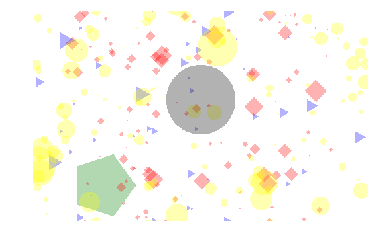

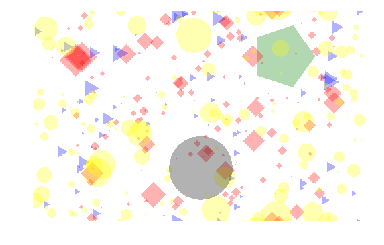

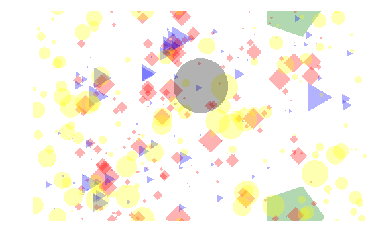

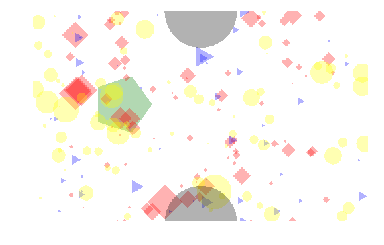

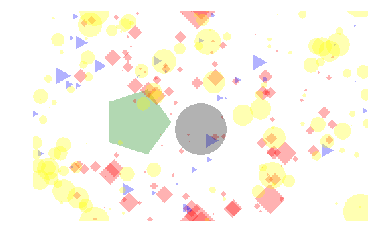

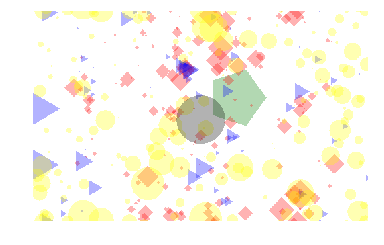

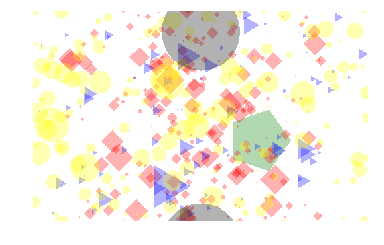

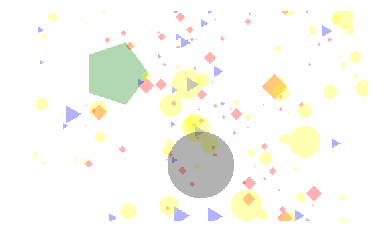

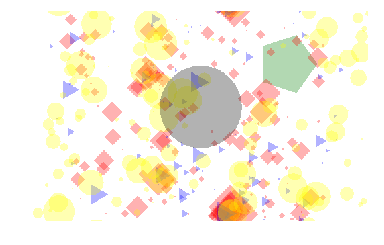

In [21]:
for x in wjets_test_images:
    data = np.asarray(x.image)
    img = create3D(data)
    showImage(img)

## Prepare the data for training
- Encode the labels
- split the data into train and test sets

In [22]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from distkeras.trainers import *
from distkeras.predictors import *
from distkeras.transformers import *
from distkeras.evaluators import *
from distkeras.utils import *

Using TensorFlow backend.


In [23]:
#
# assign labels in alphabetical order
#
qcd_label = 0
ttbar_label = 1
wjets_label = 2

#
# create new columns for that
#
qcd_sample = qcd_images.withColumn("label", lit(qcd_label))
ttbar_sample = ttbar_images.withColumn("label", lit(ttbar_label))
wjets_sample = wjets_images.withColumn("label", lit(wjets_label))

#
# combine all of that in just 1 data frame
#
data_sample = qcd_sample.union(ttbar_sample).union(wjets_sample)

In [24]:
#
# perform a quick (__not that quick__) count of number of rows
#
#data_sample.count()

#
# Should be 39447519 events total
#

### Apply HotOneEncoder

In [25]:
#
# we have 3 classes for our Classifier
#
num_classes = 3
encoder = OneHotTransformer(num_classes, input_col="label", output_col="label_encoded")
data_sample_encoded = encoder.transform(data_sample)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 12.0 failed 4 times, most recent failure: Lost task 0.3 in stage 12.0 (TID 15, p05151113628212.cern.ch, executor 7): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/worker.py", line 163, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/worker.py", line 54, in read_command
    command = serializer._read_with_length(file)
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/serializers.py", line 169, in _read_with_length
    return self.loads(obj)
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/serializers.py", line 434, in loads
    return pickle.loads(obj)
  File "/afs/cern.ch/user/v/vkhriste/.local/lib/python2.7/site-packages/distkeras/utils.py", line 5, in <module>
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/__init__.py", line 2, in <module>
    from . import backend
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/backend/__init__.py", line 64, in <module>
    from .tensorflow_backend import *
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/backend/tensorflow_backend.py", line 1, in <module>
    import tensorflow as tf
ImportError: No module named tensorflow

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:441)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/worker.py", line 163, in main
    func, profiler, deserializer, serializer = read_command(pickleSer, infile)
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/worker.py", line 54, in read_command
    command = serializer._read_with_length(file)
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/serializers.py", line 169, in _read_with_length
    return self.loads(obj)
  File "/cvmfs/sft.cern.ch/lcg/releases/spark/2.1.0-96b20/x86_64-slc6-gcc49-opt/python/pyspark/serializers.py", line 434, in loads
    return pickle.loads(obj)
  File "/afs/cern.ch/user/v/vkhriste/.local/lib/python2.7/site-packages/distkeras/utils.py", line 5, in <module>
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/__init__.py", line 2, in <module>
    from . import backend
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/backend/__init__.py", line 64, in <module>
    from .tensorflow_backend import *
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_88/x86_64-slc6-gcc49-opt/lib/python2.7/site-packages/Keras-1.1.0-py2.7.egg/keras/backend/tensorflow_backend.py", line 1, in <module>
    import tensorflow as tf
ImportError: No module named tensorflow

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:87)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
